In [1]:
print('hello world')

hello world


In [26]:
from code.computations import evaluation_w2v as ev
from code.preprocessing import load_data as ld
import os
import pandas as pd
from gensim.models import Word2Vec
import optuna

In [3]:
os.chdir(r"C:/BA_thesis/BA_v2_31.03")

print(f"working directory: {os.getcwd()}")
input_path = os.getcwd() + '/files/corpus_data'

corpus = ld.TxtSubdirsCorpus("files/dfs")

working directory: C:\BA_thesis\BA_v2_31.03
Corpus active! Path: files/dfs 



In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
def print_w2v_evalutaion_results(df: pd.DataFrame, external_sim_score: str, internal_sim_score: str, model_name: str):
    # the best model is the first one

    ess = external_sim_score
    print(f"ess: {ess}")
    iss = internal_sim_score
    print(f"iss: {iss}")
    sns.set_theme(style="ticks")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df,
                    x=iss,
                    y=ess,
                    hue=model_name,
                    palette="hls",
                    s=100,
                    alpha=0.8,
                    legend=False)

    best_row = df.iloc[0]
    second_row = df.iloc[1]
    third_row = df.iloc[2]

    rows = [best_row, second_row, third_row]
    for row in rows:
        plt.scatter(row[iss],
                    row[ess],
                    s=90,
                    edgecolor='black',
                    facecolor='red',
                    linewidth=1)

        plt.text(row[iss] + 0.005,
                 row[ess] - 0.0005,
                 f"{row[model_name]}",
                 fontsize=9,
                 color='black')

    plt.title("Evaluation Results", fontsize=14, fontweight="bold")
    plt.xlabel("Mean similarity score for chosen word-pairs", fontsize=12, fontweight="bold")
    plt.ylabel("Accuracy score computed with Google test-set", fontsize=12, fontweight="bold")
    # plt.legend(title="Model", loc='best', prop={'size': 8})
    plt.tight_layout()
    plt.show()

In [4]:
def train_w2v_models(trial):
    window = trial.suggest_int("window", 2, 3)
    epochs = trial.suggest_int("epochs", 100, 150)
    sg = trial.suggest_int("sg", 0, 1)
    vector_size = trial.suggest_int("vector_size", 100, 120)
    print(f'\nTraining of w{window}e{epochs}sg{sg}v{vector_size} has started.')
    w2v = Word2Vec(
        sentences=corpus,
        window=window,
        min_count=5,
        epochs=epochs,
        sg=sg,
        vector_size=vector_size
    )

    e = ev.evaluate_model(w2v,
                          ev_file='files/google.txt',
                          test_words=[('good', 'bad'), ('game', 'theory')])

    return e


study = optuna.create_study(directions=["maximize", "maximize"],
                            study_name='w2v_optimization')
study.optimize(train_w2v_models, n_trials=3)

[I 2025-04-19 14:35:57,150] A new study created in memory with name: w2v_optimization



Training of w2e104sg0v115 has started.


[I 2025-04-19 14:36:24,424] Trial 0 finished with values: [0.10800018161535263, 0.0] and parameters: {'window': 2, 'epochs': 104, 'sg': 0, 'vector_size': 115}.


Model [Word2Vec<vocab=3386, vector_size=115, alpha=0.025>] was evaluated:
Custom similarity score: 0.10800018161535263
External accuracy: 0.0

Training of w3e149sg0v116 has started.


[I 2025-04-19 14:36:57,722] Trial 1 finished with values: [0.048588138073682785, 0.025] and parameters: {'window': 3, 'epochs': 149, 'sg': 0, 'vector_size': 116}.


Model [Word2Vec<vocab=3386, vector_size=116, alpha=0.025>] was evaluated:
Custom similarity score: 0.048588138073682785
External accuracy: 0.025

Training of w2e147sg0v115 has started.


[I 2025-04-19 14:37:31,498] Trial 2 finished with values: [0.10274393111467361, 0.0125] and parameters: {'window': 2, 'epochs': 147, 'sg': 0, 'vector_size': 115}.


Model [Word2Vec<vocab=3386, vector_size=115, alpha=0.025>] was evaluated:
Custom similarity score: 0.10274393111467361
External accuracy: 0.0125


In [36]:
trial = study.best_trials
df = study.trials_dataframe()
df.rename(columns={'values_0': 'custom_sim_score', 'values_1': 'external_accuracy'}, inplace=True)
df['model_name'] = 'w' + str(df['params_window'][0]) + 'e' + str(df['params_epochs'][0]) + 'sg' + str(df['params_sg'][0]) + 'v' + str(df['params_vector_size'][0])
df.head()

,number,custom_sim_score,external_accuracy,datetime_start,datetime_complete,duration,params_epochs,params_sg,params_vector_size,params_window,system_attrs_NSGAIISampler:generation,state,model_name
0,0,0.108000,0.0000,2025-04-19 14:35:57.150403,2025-04-19 14:36:24.424841,0 days 00:00:27.274438,104,0,115,2,0,COMPLETE,w2e104sg0v115
1,1,0.048588,0.0250,2025-04-19 14:36:24.425840,2025-04-19 14:36:57.722166,0 days 00:00:33.296326,149,0,116,3,0,COMPLETE,w2e104sg0v115
2,2,0.102744,0.0125,2025-04-19 14:36:57.722166,2025-04-19 14:37:31.498195,0 days 00:00:33.776029,147,0,115,2,0,COMPLETE,w2e104sg0v115


ess: external_accuracy
iss: custom_sim_score


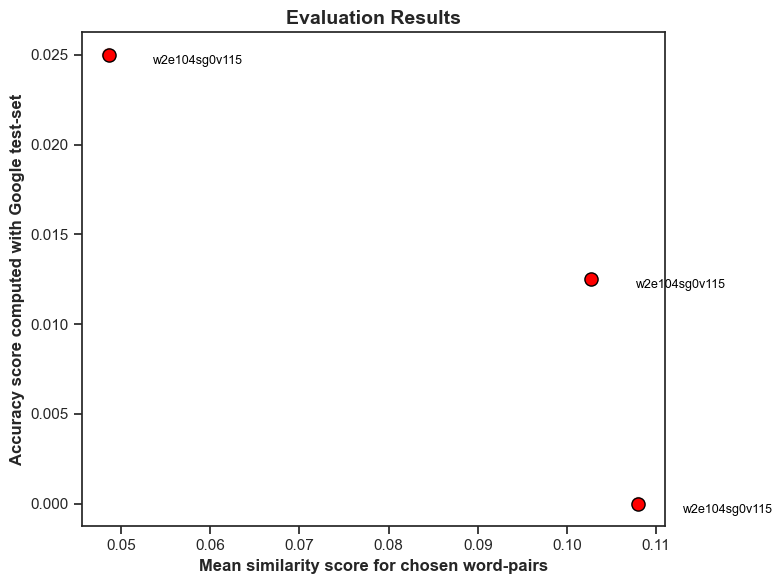

In [37]:
print_w2v_evalutaion_results(df=df,
                             external_sim_score='external_accuracy',
                             internal_sim_score='custom_sim_score',
                             model_name='model_name')